In [1]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import zipfile
import glob
import os
import random
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split

#importing various metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

# importing model relevant dependencies
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras import optimizers, regularizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.callbacks import EarlyStopping, LearningRateScheduler

from keras import backend as K
K.clear_session()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# extracting train and test data from zipfiles to data folder
zip_files = glob.glob('/kaggle/input/dogs-vs-cats/*.zip')
print("{} files found in the input directory".format(len(zip_files)))

2 files found in the input directory


In [4]:
for file in zip_files:
    with zipfile.ZipFile(file,'r') as Z:
        Z.extractall('data')
    print('{} extraction complete'.format(file.split('/')[-1]))

test1.zip extraction complete
train.zip extraction complete


In [5]:
# EDA with images in the directory
train_dir = '/kaggle/working/data/train'
test_dir = '/kaggle/working/data/test1'

print("{} is the count of images in train_dir".format(len(os.listdir(train_dir))))
print("{} is the count of images in test_dir".format(len(os.listdir(test_dir))))

25000 is the count of images in train_dir
12500 is the count of images in test_dir


In [6]:
# let's explore a sample file and how to extract label and file name from it.

for _ in range(5):
    print(random.choice(os.listdir(train_dir)))

dog.10240.jpg
dog.8942.jpg
cat.1849.jpg
dog.3186.jpg
cat.8778.jpg


In [7]:
# saving extracted data into dataframe for further processing
def label(path):
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

x_train_images_name = filename(train_dir)
x_test_images_name = filename(test_dir)
y_train_label_name = label(train_dir)

#creating df with name and label

df_train_image = pd.DataFrame({'filename':x_train_images_name, 'label':y_train_label_name})
df_submission = pd.DataFrame({'filename':x_test_images_name})

In [8]:
df_train_image.head()

,filename,label
0,cat.8071.jpg,cat
1,dog.30.jpg,dog
2,cat.9551.jpg,cat
3,dog.7794.jpg,dog
4,cat.3503.jpg,cat


In [9]:
df_submission.head()

,filename
0,12220.jpg
1,3477.jpg
2,11598.jpg
3,5176.jpg
4,713.jpg


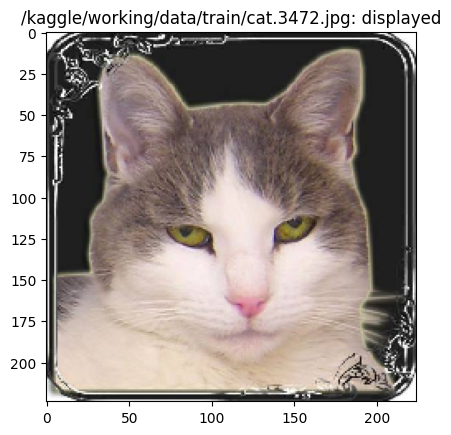

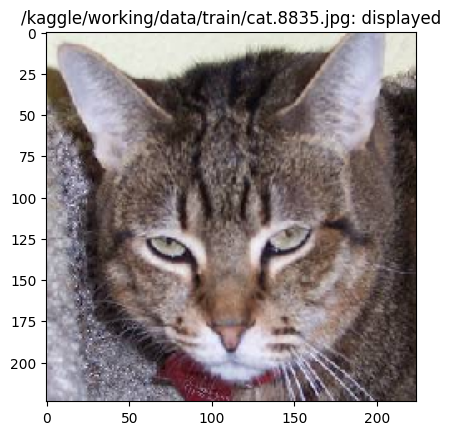

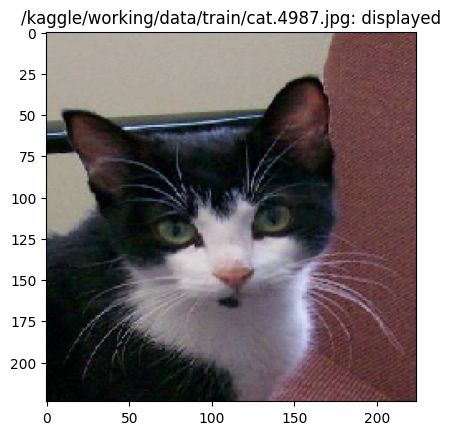

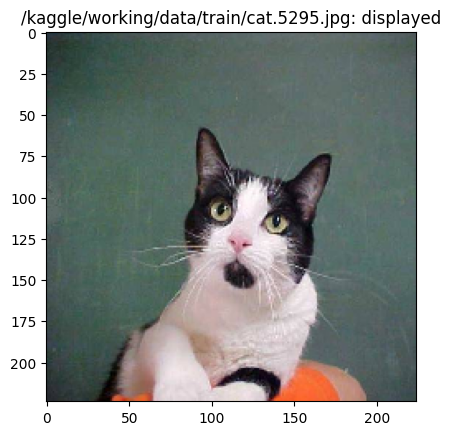

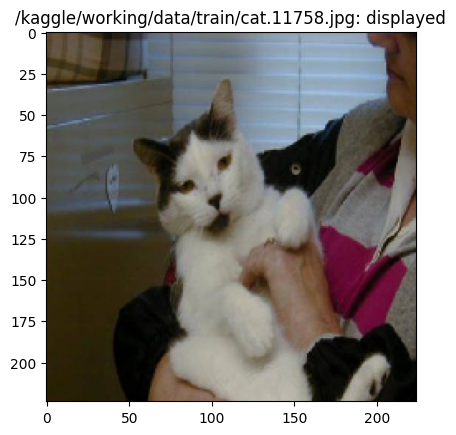

In [10]:
# training directory
for _ in range(5):
    file_name = train_dir + "/"+ random.choice(os.listdir(train_dir))
    #read image
    image = load_img(file_name, target_size=(224,224))
    plt.imshow(image)
    plt.title("{}: displayed".format(file_name))
    plt.show()
    

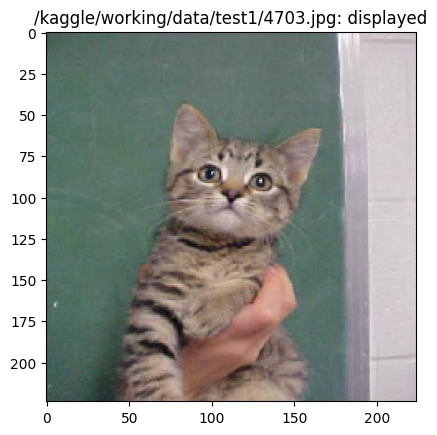

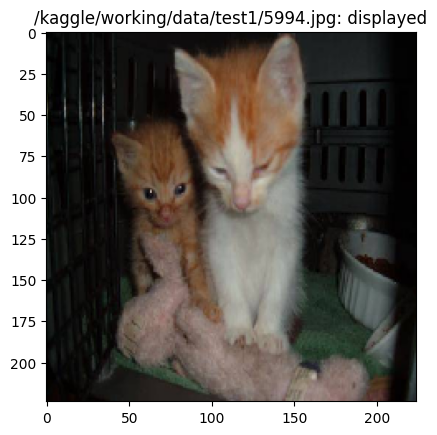

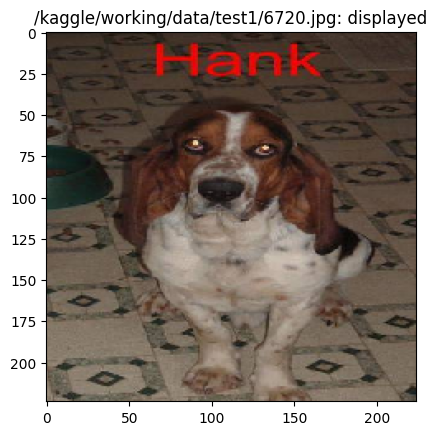

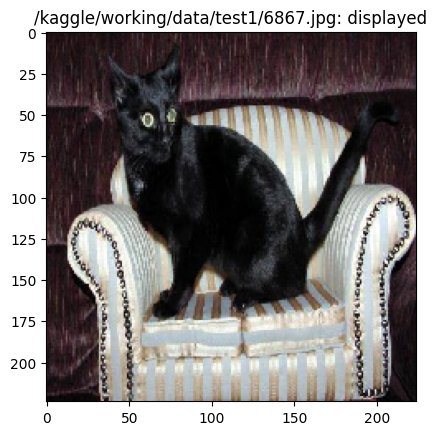

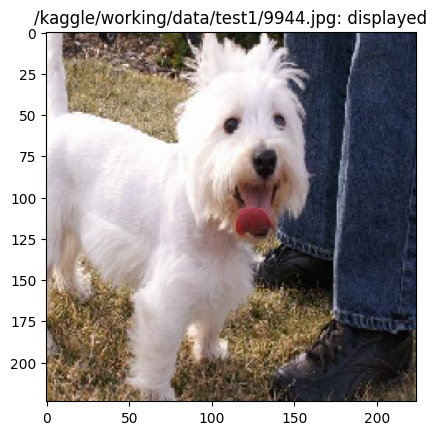

In [11]:
# test directory
for _ in range(5):
    file_name = test_dir + "/"+ random.choice(os.listdir(test_dir))
    #read image
    image = load_img(file_name, target_size=(224,224))
    plt.imshow(image)
    plt.title("{}: displayed".format(file_name))
    plt.show()

In [12]:
# splitting the data into train test
train_val_df, test_df = train_test_split(df_train_image, test_size=0.02)
# splitting the train val further into train, val
train_df, val_df = train_test_split(train_val_df, test_size=0.2)

print("Total number of images in the train is {}".format(train_df.shape[0]))
print("Total number of images in the internal test is {}".format(test_df.shape[0]))
print("Total number of images in the val is {}".format(val_df.shape[0]))
print("Total number of images in the submission is {}".format(df_submission.shape[0]))

Total number of images in the train is 19600
Total number of images in the internal test is 500
Total number of images in the val is 4900
Total number of images in the submission is 12500


<AxesSubplot: xlabel='label', ylabel='count'>

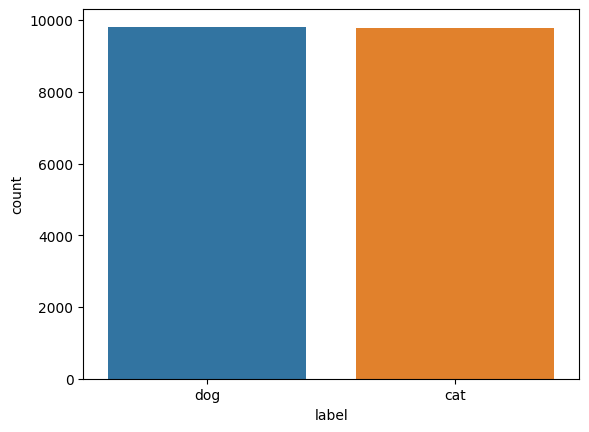

In [13]:
# checking the data distribution within each train,val and internal testing data.
sns.countplot(x ='label', data = train_df)

<AxesSubplot: xlabel='label', ylabel='count'>

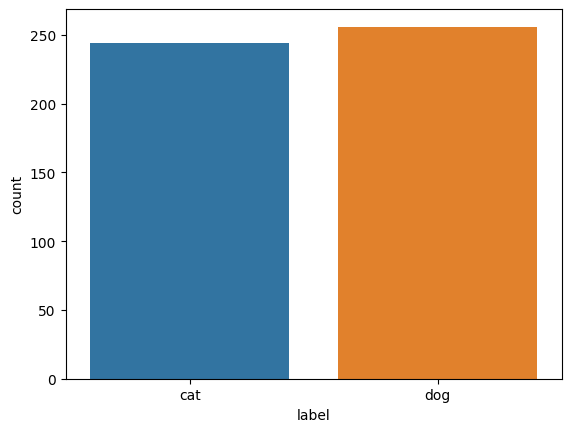

In [14]:
sns.countplot(x ='label', data = test_df)


In [15]:
# Image augmentation data preparation with Image Data Generator
img_size = 224
batch_size = 1024 
train_aug_map = ImageDataGenerator(
                rotation_range=10,
                horizontal_flip = True,
                fill_mode = 'nearest',
                preprocessing_function = preprocess_input)

train_data = train_aug_map.flow_from_dataframe(
                            train_df, train_dir,
                            x_col='filename',
                            y_col = 'label',
                            target_size = (img_size, img_size),
                            batch_size= batch_size,
                            class_mode='binary')


val_aug_mag = ImageDataGenerator(
                preprocessing_function = preprocess_input)

val_data = val_aug_mag.flow_from_dataframe(
                            val_df, train_dir,
                            x_col='filename',
                            y_col = 'label',
                            target_size = (img_size, img_size),
                            batch_size= batch_size,
                            class_mode='binary')

test_aug_map = ImageDataGenerator(
                preprocessing_function = preprocess_input)

test_data = val_aug_mag.flow_from_dataframe(
                            test_df, train_dir,
                            x_col='filename',
                            y_col = None,
                            class_mode = None,
                            target_size = (img_size, img_size),
                            shuffle = False)


Found 19600 validated image filenames belonging to 2 classes.
Found 4900 validated image filenames belonging to 2 classes.
Found 500 validated image filenames.


# MobileNet Model

In [16]:
# building mobile net model
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet.trainable = False
mobilenet_model = Sequential([mobilenet,Flatten(),Dense(1024, activation='relu'),
                             Dropout(0.4), Dense(1,activation='sigmoid')])

optimizer = tf.keras.optimizers.Adam(1e-6)

mobilenet_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1024)              64226304  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 66,485,313
Trainable params: 64,227,329
Non-t

In [17]:
# early stopping criterion

epoch = 50
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def adjustable_lr(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr
    
    
early_stop = EarlyStopping(patience=5)
lr_callback = LearningRateScheduler(adjustable_lr, verbose=True)
callbacks = [early_stop, lr_callback]


In [18]:
train_images = train_df.shape[0]
val_images = val_df.shape[0]

In [20]:
mobilenet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
train_images = train_df.shape[0]
val_images = val_df.shape[0]
history = mobilenet_model.fit_generator(train_data, epochs=20, validation_data=val_data, validation_steps=val_images//batch_size, steps_per_epoch=train_images//batch_size, callbacks=callbacks)

/tmp/ipykernel_32/1098993176.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobilenet_model.fit_generator(train_data, epochs=20, validation_data=val_data, validation_steps=val_images//batch_size, steps_per_epoch=train_images//batch_size, callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 1e-08.
Epoch 1/20
76/76 [==============================] - 248s 3s/step - loss: 1.0847 - accuracy: 0.4882 - val_loss: 0.9274 - val_accuracy: 0.4854 - lr: 1.0000e-08

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/20
76/76 [==============================] - 245s 3s/step - loss: 0.1477 - accuracy: 0.9691 - val_loss: 0.0807 - val_accuracy: 0.9829 - lr: 3.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/20
76/76 [==============================] - 236s 3s/step - loss: 0.0573 - accuracy: 0.9856 - val_loss: 0.0524 - val_accuracy: 0.9842 - lr: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
Epoch 4/20
76/76 [==============================] - 242s 3s/step - loss: 0.0368 - accuracy: 0.9875 - val_loss: 0.0456 - val_accuracy: 0.9838 - lr: 2.4200e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
Epoch 5/20
76/

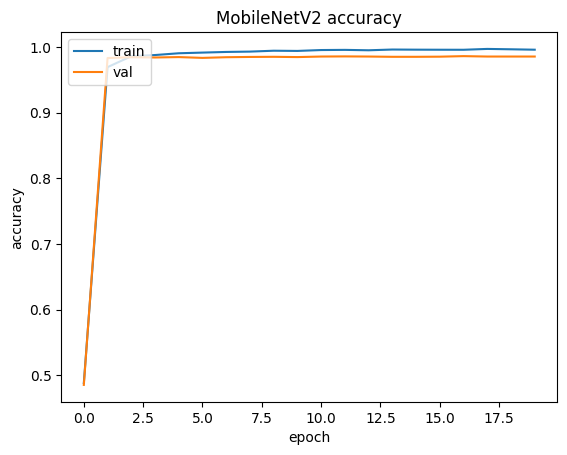

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNetV2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

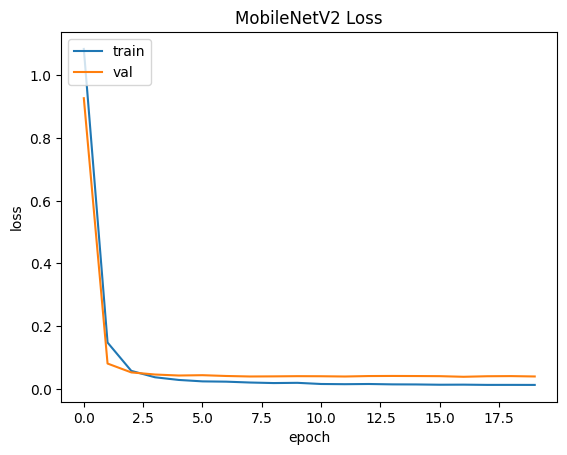

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNetV2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
mobilenet_scores = mobilenet_model.evaluate(val_data, steps=val_images//batch_size, verbose=0)
mobilenet_loss, mobilenet_accuracy = mobilenet_scores[0], mobilenet_scores[1]
print(f"MobileNet validation loss: {mobilenet_loss:.4f}")
print(f"MobileNet validation accuracy: {mobilenet_accuracy:.4f}")

MobileNet validation loss: 0.0403
MobileNet validation accuracy: 0.9852


In [24]:
test_images = test_df.shape[0]


In [25]:
mobilenet_model.save('My_Mobilenet_model_transfer_learning_model')


In [26]:
mobilenet_v2_pred = mobilenet_model.predict_generator(test_data)
test_df['prediction'] = np.argmax(mobilenet_v2_pred, axis=-1)
labels = dict((v,k) for k,v in train_data.class_indices.items())
test_df['prediction'] = test_df['prediction'].map(labels)

/tmp/ipykernel_32/766248473.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  mobilenet_v2_pred = mobilenet_model.predict_generator(test_data)


In [27]:
import tensorflow as tf

# load the saved model
model = tf.keras.models.load_model('My_Mobilenet_model_transfer_learning_model')

# use the model for inference
result = model.predict(test_data)

16/16 [==============================] - 2s 69ms/step


In [28]:
mobilenet_confusion_matrix = confusion_matrix(test_df['label'], test_df['prediction'])
print(mobilenet_confusion_matrix)

[[244   0]
 [256   0]]


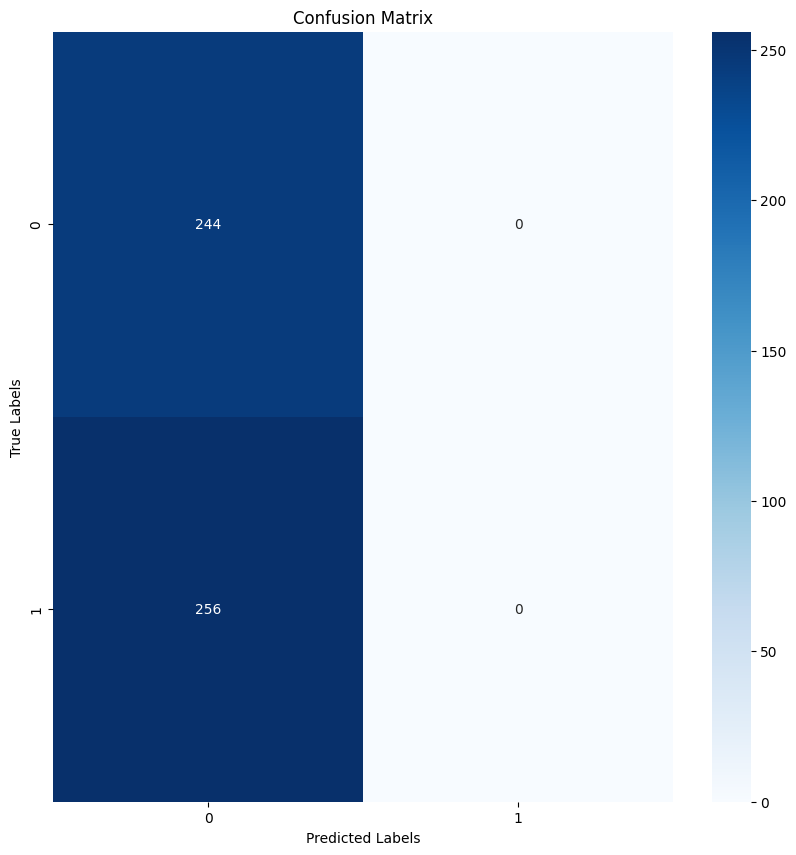

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix
confusion_matrix = mobilenet_confusion_matrix

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()

# AlexNet Model

In [30]:
alexnet_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [31]:
# Compile the model
alexnet_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
# Train the model
history_Alex=alexnet_model.fit(train_data, 
          epochs=20, validation_data=val_data,validation_steps=val_images//batch_size,
                  steps_per_epoch=train_images//batch_size, callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 1e-08.
Epoch 1/20
76/76 [==============================] - 253s 3s/step - loss: 0.6930 - accuracy: 0.5033 - val_loss: 0.6930 - val_accuracy: 0.4959 - lr: 1.0000e-08

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/20
76/76 [==============================] - 252s 3s/step - loss: 0.6537 - accuracy: 0.6055 - val_loss: 0.6058 - val_accuracy: 0.6669 - lr: 3.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/20
76/76 [==============================] - 238s 3s/step - loss: 0.5609 - accuracy: 0.7076 - val_loss: 0.5052 - val_accuracy: 0.7444 - lr: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
Epoch 4/20
76/76 [==============================] - 238s 3s/step - loss: 0.4865 - accuracy: 0.7678 - val_loss: 0.4778 - val_accuracy: 0.7710 - lr: 2.4200e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
Epoch 5/20
76/

In [33]:
alexnet_scores = alexnet_model.evaluate(val_data, steps=val_images//batch_size, verbose=0)
alexnet_loss, alexnet_accuracy = alexnet_scores[0], alexnet_scores[1]
print(f"AlexNet validation loss: {alexnet_loss:.4f}")
print(f"AlexNet Test accuracy: {alexnet_accuracy:.4f}")

AlexNet validation loss: 0.3546
AlexNet Test accuracy: 0.8472


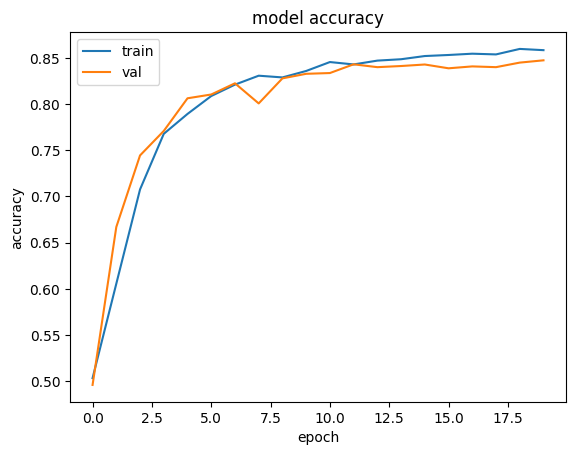

In [34]:
plt.plot(history_Alex.history['accuracy'])
plt.plot(history_Alex.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

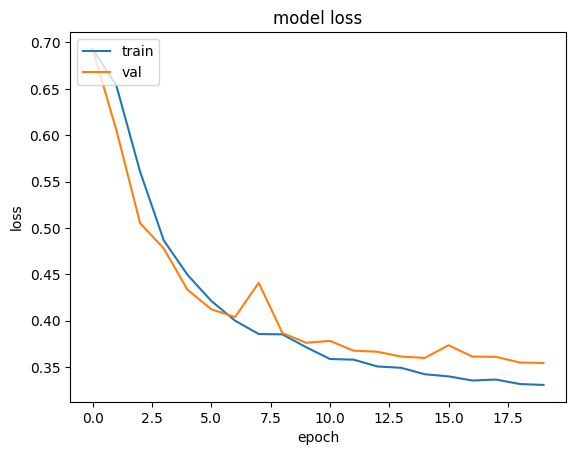

In [35]:
plt.plot(history_Alex.history['loss'])
plt.plot(history_Alex.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [36]:
alexnet_model.save('My_Alexnet_transfer_learning_model')


In [37]:

import tensorflow as tf

# load the saved model
model = tf.keras.models.load_model('My_Alexnet_transfer_learning_model')

# use the model for inference
result = model.predict(test_data)

16/16 [==============================] - 2s 75ms/step


In [38]:
Alexnet_pred = alexnet_model.predict_generator(test_data)
test_df['prediction'] = np.argmax(Alexnet_pred, axis=-1)
labels = dict((v,k) for k,v in train_data.class_indices.items())
test_df['prediction'] = test_df['prediction'].map(labels)

/tmp/ipykernel_32/3216070840.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Alexnet_pred = alexnet_model.predict_generator(test_data)


In [42]:
from sklearn.metrics import confusion_matrix
Alexnet_confusion_matrix = confusion_matrix(test_df['label'], test_df['prediction'])
print(Alexnet_confusion_matrix)

[[244   0]
 [256   0]]


In [ ]:
# Make predictions on the test data
predictions = alexnet_model.predict(test_data)

# Convert predicted probabilities into predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, predicted_labels)

# Print confusion matrix
print(confusion_matrix)

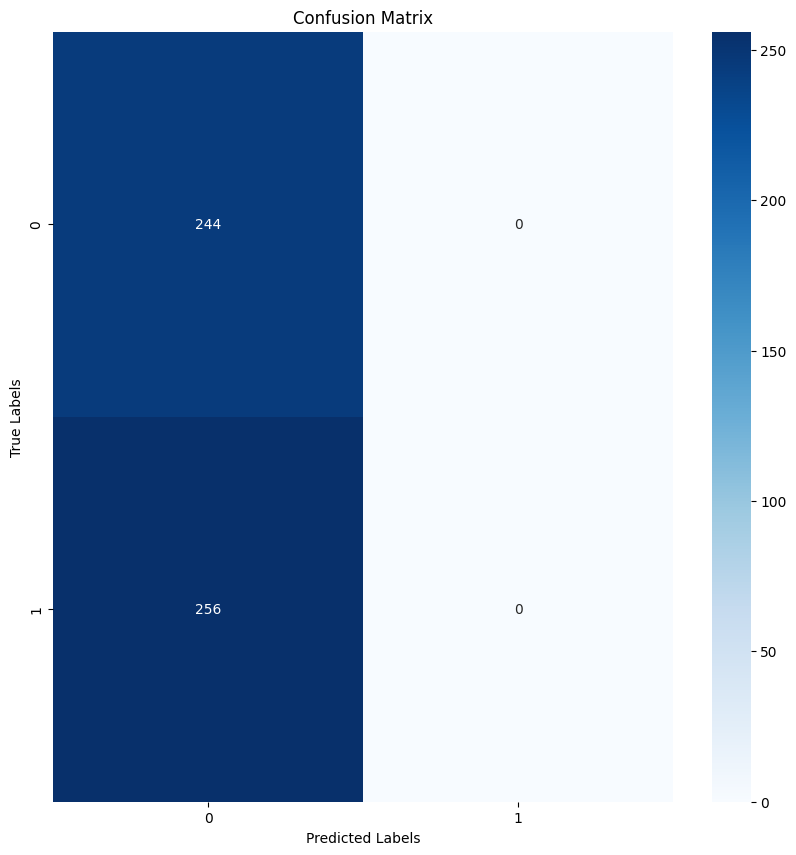

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix
confusion_matrix = Alexnet_confusion_matrix

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()

# VGG19 MODEL

In [44]:
from keras.applications.vgg19 import VGG19
from keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam


# Define the input image dimensions
img_width, img_height = 224, 224

# Create the VGG19 model, set the input shape to (img_width, img_height, 3)
base_model = VGG19(input_shape=(img_width, img_height, 3), include_top=False)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base model with the new classification head
VGG19_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
VGG19_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 [==============================] - 4s 0us/step


In [45]:
# Train the model
history_VGG19=VGG19_model.fit(train_data, 
          epochs=20, validation_data=val_data,validation_steps=val_images//batch_size,
                  steps_per_epoch=train_images//batch_size, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 1e-08.
Epoch 1/20
76/76 [==============================] - 278s 3s/step - loss: 0.7957 - accuracy: 0.5004 - val_loss: 0.7984 - val_accuracy: 0.4965 - lr: 1.0000e-08

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/20
76/76 [==============================] - 247s 3s/step - loss: 0.6801 - accuracy: 0.6031 - val_loss: 0.6191 - val_accuracy: 0.8030 - lr: 3.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/20
76/76 [==============================] - 251s 3s/step - loss: 0.5895 - accuracy: 0.8561 - val_loss: 0.5439 - val_accuracy: 0.8917 - lr: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
Epoch 4/20
76/76 [==============================] - 252s 3s/step - loss: 0.5309 - accuracy: 0.8844 - val_loss: 0.4942 - val_accuracy: 0.8984 - lr: 2.4200e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
Epoch 5/20
76/

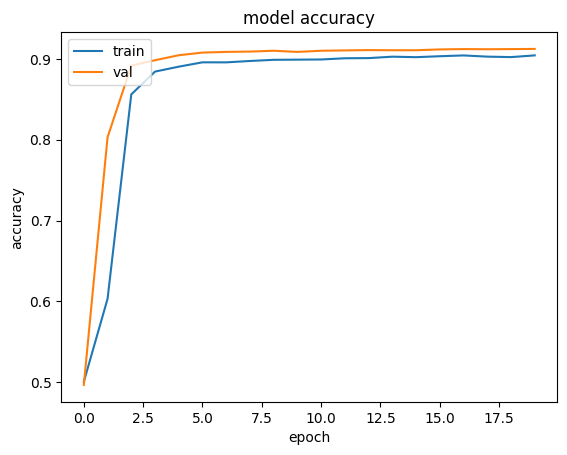

In [46]:
plt.plot(history_VGG19.history['accuracy'])
plt.plot(history_VGG19.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

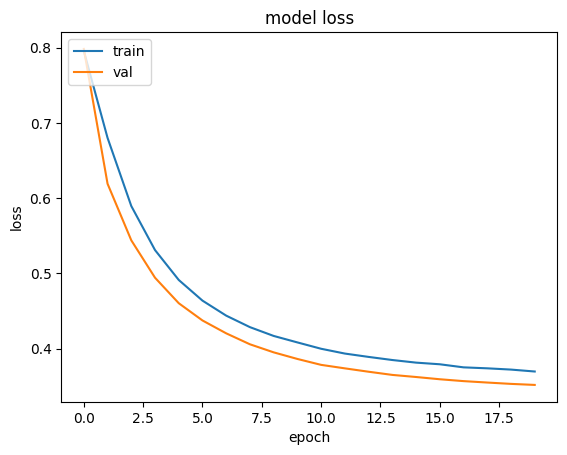

In [47]:
plt.plot(history_VGG19.history['loss'])
plt.plot(history_VGG19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
VGG19_scores = VGG19_model.evaluate(val_data, steps=val_images//batch_size, verbose=0)
VGG19_loss, VGG19_accuracy = VGG19_scores[0], VGG19_scores[1]
print(f"VGG19 validation loss: {VGG19_loss:.4f}")
print(f"VGG19 validation accuracy: {VGG19_accuracy:.4f}")

VGG19 validation loss: 0.3517
VGG19 validation accuracy: 0.9120


In [49]:
VGG19_model.save('My_VGG19_transfer_learning_model')


In [50]:

import tensorflow as tf

# load the saved model
model = tf.keras.models.load_model('My_VGG19_transfer_learning_model')

# use the model for inference
result = model.predict(test_data)

16/16 [==============================] - 7s 209ms/step


# InceptionNet Model

In [51]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.applications.inception_v3 import InceptionV3

# create an instance of the InceptionV3 model with pre-trained weights
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the layers in the base model
for layer in inception_model.layers:
    layer.trainable = False

# add custom classification layers on top of the base model
x = Flatten()(inception_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# create the final model
model_Inception = Model(inputs=inception_model.input, outputs=x)

# compile the model
model_Inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 4s 0us/step


In [52]:
history_Inception=model_Inception.fit(train_data, epochs=20, validation_data=val_data, validation_steps=val_images//batch_size, steps_per_epoch=train_images//batch_size, callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 1e-08.
Epoch 1/20
76/76 [==============================] - 258s 3s/step - loss: 1.0602 - accuracy: 0.5204 - val_loss: 1.0334 - val_accuracy: 0.5228 - lr: 1.0000e-08

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/20
76/76 [==============================] - 246s 3s/step - loss: 0.4269 - accuracy: 0.9135 - val_loss: 0.0435 - val_accuracy: 0.9846 - lr: 3.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/20
76/76 [==============================] - 239s 3s/step - loss: 0.0450 - accuracy: 0.9839 - val_loss: 0.0375 - val_accuracy: 0.9864 - lr: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
Epoch 4/20
76/76 [==============================] - 248s 3s/step - loss: 0.0390 - accuracy: 0.9861 - val_loss: 0.0342 - val_accuracy: 0.9883 - lr: 2.4200e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
Epoch 5/20
76/

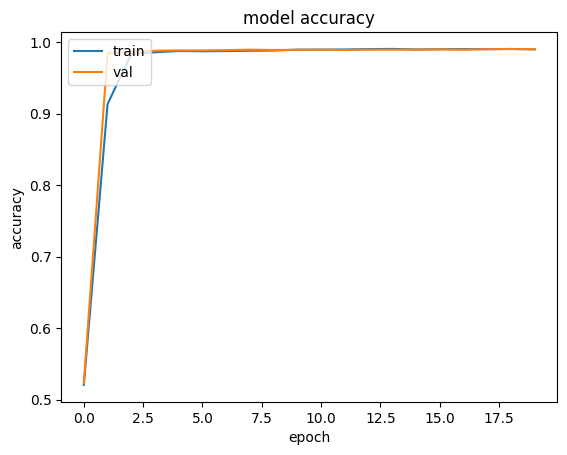

In [58]:
plt.plot(history_Inception.history['accuracy'])
plt.plot(history_Inception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

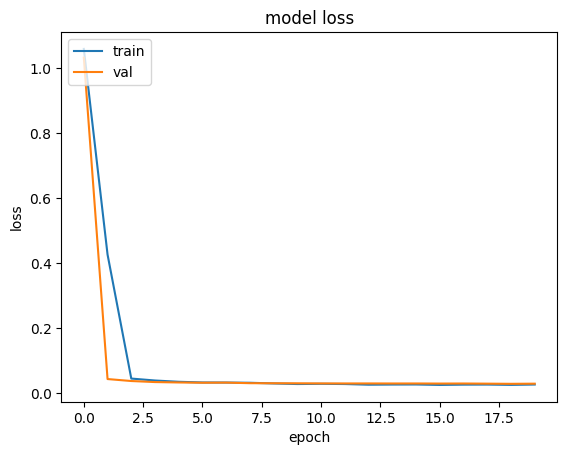

In [59]:
plt.plot(history_Inception.history['loss'])
plt.plot(history_Inception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
Inception_scores = model_Inception.evaluate(val_data, steps=val_images//batch_size, verbose=0)
Inception_loss, Inception_accuracy = Inception_scores[0], Inception_scores[1]
print(f"Inception validation loss: {Inception_loss:.4f}")
print(f"Inception validation accuracy: {Inception_accuracy:.4f}")

Inception validation loss: 0.0296
Inception validation accuracy: 0.9901


In [63]:
model_Inception.save('My_Inception_transfer_learning_model')


In [64]:

import tensorflow as tf

# load the saved model
model = tf.keras.models.load_model('My_Inception_transfer_learning_model')

# use the model for inference
result = model.predict(test_data)

16/16 [==============================] - 3s 94ms/step


# Resnet 50  MODEL

In [65]:
# define ResNet50 model
resnet_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                              weights='imagenet',
                                              include_top=False)

for layer in resnet_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
ResNet50_model = tf.keras.Model(inputs=resnet_model.input, outputs=output)


94765736/94765736 [==============================] - 5s 0us/step


In [67]:
# Compile model
ResNet50_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [69]:
# Train model
Resnet50_history = ResNet50_model.fit(train_data,
                             epochs=20,
                             validation_data=val_data
                            ,validation_steps=val_images//batch_size,
                             steps_per_epoch=train_images//batch_size,
                            callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 1e-08.
Epoch 1/20
76/76 [==============================] - 249s 3s/step - loss: 0.8186 - accuracy: 0.5018 - val_loss: 0.8065 - val_accuracy: 0.4942 - lr: 1.0000e-08

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/20
76/76 [==============================] - 251s 3s/step - loss: 0.7148 - accuracy: 0.5216 - val_loss: 0.6651 - val_accuracy: 0.6059 - lr: 3.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/20
76/76 [==============================] - 247s 3s/step - loss: 0.6782 - accuracy: 0.5696 - val_loss: 0.6521 - val_accuracy: 0.6244 - lr: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
Epoch 4/20
76/76 [==============================] - 247s 3s/step - loss: 0.6685 - accuracy: 0.5853 - val_loss: 0.6487 - val_accuracy: 0.6254 - lr: 2.4200e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
Epoch 5/20
76/

In [72]:
# Evaluate model
test_loss, test_acc = ResNet50_model.evaluate(val_data)
print('Resnet 50 Test accuracy:', test_acc)
print('Resnet 50 Test Loss:', test_loss)

20/20 [==============================] - 15s 748ms/step - loss: 0.6355 - accuracy: 0.6384
Resnet 50 Test accuracy: 0.6383673548698425
Resnet 50 Test Loss: 0.6355072855949402


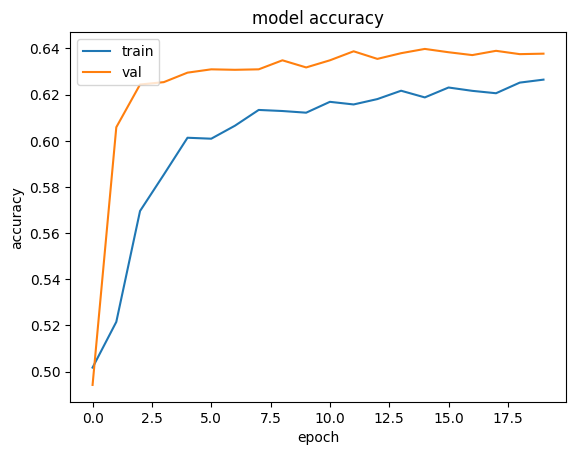

In [73]:
plt.plot(Resnet50_history.history['accuracy'])
plt.plot(Resnet50_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

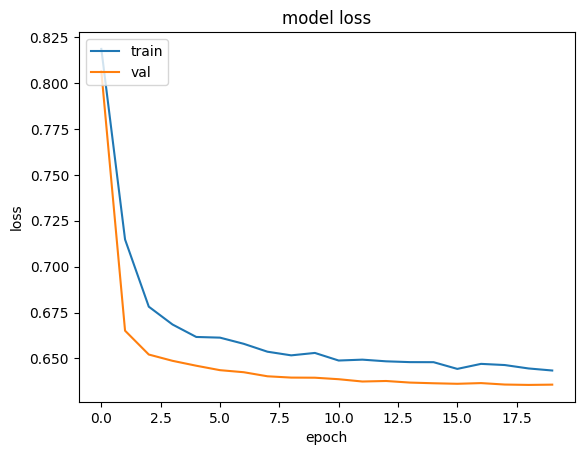

In [74]:
plt.plot(Resnet50_history.history['loss'])
plt.plot(Resnet50_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [75]:
ResNet50_model.save('My_Resnet50_transfer_learning_model')



In [76]:
import tensorflow as tf

# load the saved model
model = tf.keras.models.load_model('My_Resnet50_transfer_learning_model')

# use the model for inference
result = model.predict(test_data)

16/16 [==============================] - 3s 82ms/step


# Information About Models

In [115]:
history_Alex.history['accuracy'][-1]

0.8584573864936829

In [120]:
history_VGG19.history['loss'][-1]

0.3695005476474762

In [126]:
model_Inception.layers[-1].activation.__name__

'sigmoid'

In [128]:
import pandas as pd

# Define hyperparameters
Mobilenet_hp = {
    'accuracy': history.history['accuracy'][-1],
   'loss': history.history['loss'][-1],
  'parameters': mobilenet_model.count_params(),
  'epochs': 20.0,
   'optimizer':mobilenet_model.optimizer.__class__.__name__,
  'early_stopping': 5.0,
    'num_layers': len(mobilenet_model.layers),
    'activation_function': mobilenet_model.layers[-1].activation.__name__
}

InceptionnetV3_hp = {
    'accuracy': history_Inception.history['accuracy'][-1],
    'loss': history_Inception.history['loss'][-1],
    'parameters': model_Inception.count_params(),
    'epochs': 20.0,
    'optimizer': model_Inception.optimizer.__class__.__name__,
    'early_stopping': 5.0,
    'num_layers': len(model_Inception.layers),
    'activation_function':model_Inception.layers[-1].activation.__name__
}

Alexnet_hp = {
    'accuracy': history_Alex.history['accuracy'][-1],
    'loss': history_Alex.history['loss'][-1],
    'parameters': alexnet_model.count_params(),
    'epochs': 20.0,
    'optimizer': alexnet_model.optimizer.__class__.__name__,
    'early_stopping': 5.0,
    'num_layers': len(alexnet_model.layers),
    'activation_function': alexnet_model.layers[-1].activation.__name__
}

VGG19_hp = {
    'accuracy': history_VGG19.history['accuracy'][-1],
    'loss': history_VGG19.history['loss'][-1],
    'parameters': VGG19_model.count_params(),
    'epochs': 20.0,
    'optimizer': VGG19_model.optimizer.__class__.__name__,
    'early_stopping': 5.0,
    'num_layers': len(VGG19_model.layers),
    'activation_function': VGG19_model.layers[-1].activation.__name__
}

Resnet50_hp = {
    'accuracy': Resnet50_history.history['accuracy'][-1],
    'loss': Resnet50_history.history['loss'][-1],
    'parameters': ResNet50_model.count_params(),
    'epochs': 20.0,
    'optimizer': ResNet50_model.optimizer.__class__.__name__,
    'early_stopping': 5.0,
    'num_layers': len(ResNet50_model.layers),
    'activation_function': ResNet50_model.layers[-1].activation.__name__
}

In [129]:
# Create dataframe
df = pd.DataFrame([Mobilenet_hp, InceptionnetV3_hp, Alexnet_hp,VGG19_hp,Resnet50_hp], 
                  index=['MobileNet', 'Inceptionnet V3', 'Alexnet','VGG19','Resnet50'])

In [130]:
df

,accuracy,loss,parameters,epochs,optimizer,early_stopping,num_layers,activation_function
MobileNet,0.995606,0.012440,66485313,20.0,Adam,5.0,5,sigmoid
Inceptionnet V3,0.990178,0.026651,34910497,20.0,Adam,5.0,314,sigmoid
Alexnet,0.858457,0.330654,46751105,20.0,Adam,5.0,14,sigmoid
VGG19,0.904415,0.369501,20155969,20.0,Adam,5.0,25,sigmoid
Resnet50,0.626499,0.643444,23850113,20.0,Adam,5.0,179,sigmoid


In [ ]:
# # extract hyperparameters
# hyperparameters = []
# for name, model in models.items():
#     hp = {}
#     hp['loss'] = model.history.history['loss'][-1] if model is not None else 'binary_crossentropy'
#     hp['parameters'] = model.count_params() if model is not None else 66485313
#     hp['optimizer'] = type(model.optimizer).__name__ if model is not None else '<keras.optimizers.optimizer_experimental.adam...>'
#     hp['num_layers'] = len(model.layers) if model is not None else float('NaN')
#     hp['activation_function'] = model.layers[-1].activation.__name__ if model is not None else float('NaN')
#     hp['accuracy'] = model.history.history['accuracy'][-1] if model is not None else float('NaN')
#     hp['epochs'] = 20.0
#     hp['early_stopping'] = 5.0
#     hyperparameters.append(hp)


In [69]:
# import pandas as pd

# results_df = pd.DataFrame({
#     'Model': ['AlexNet', 'MobileNet','VGG19','Inception','GoogleNet'],
#     'Accuracy': [alexnet_accuracy, mobilenet_accuracy,VGG19_accuracy,googlenet_accuracy],
#     'Validation Accuracy': [alexnet_val_accuracy, mobilenet_val_accuracy,VGG19_val_accuracy,googlenet_val_accuracy]
# })

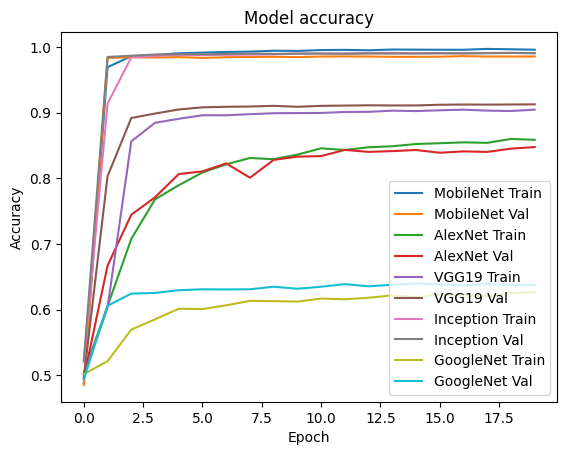

In [111]:
import matplotlib.pyplot as plt

# plot accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_Alex.history['accuracy'])
plt.plot(history_Alex.history['val_accuracy'])
plt.plot(history_VGG19.history['accuracy'])
plt.plot(history_VGG19.history['val_accuracy'])
plt.plot(history_Inception.history['accuracy'])
plt.plot(history_Inception.history['val_accuracy'])
plt.plot(Resnet50_history.history['accuracy'])
plt.plot(Resnet50_history.history['val_accuracy'])




# set plot title and labels
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([ 'MobileNet Train', 'MobileNet Val','AlexNet Train', 'AlexNet Val','VGG19 Train', 'VGG19 Val','Inception Train','Inception Val','GoogleNet Train','GoogleNet Val'], loc='lower right')

# show plot
plt.show()


# Print HyperParam About Your Own Model 

In [ ]:
# import pandas as pd
# import tensorflow as tf

# # load the saved model
# model = tf.keras.models.load_model('my_transfer_learning_model')

# # define the hyperparameters
# hyperparameters = {
#     'loss': model.loss,
#     'optimizer': model.optimizer,
#     'learning_rate': model.optimizer.learning_rate.numpy(),
#     'batch_size': model.batch_size,
#     'epochs': model.epochs,
#     'validation_split': model.validation_split,
#     'metrics': model.metrics_names,
#     'num_layers': len(model.layers),
#     'input_shape': model.input_shape[1:]
# }

# # create a DataFrame from the hyperparameters dictionary
# df = pd.DataFrame.from_dict(hyperparameters, orient='index', columns=['Value'])

# # print the DataFrame
# print(df)